# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import collections
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


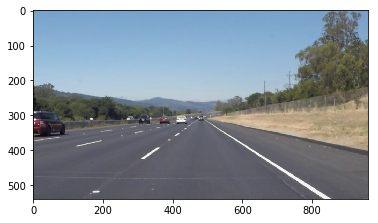

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Lane Detection Pipeline

## Helper Functions

In [10]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    imshape = img.shape
    vertices_mask = np.array([[(0,imshape[0]),vertices[0], vertices[1],
                             (imshape[1],imshape[0])]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices_mask, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# global to average line information between frames
prev_lines = collections.deque([], 5)

def reset_prev_lines():
    prev_lines.clear()
    
def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    ymax = img.shape[0]
    ymin = 320
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            icept = y1 - (slope * x1)
            # if positive slope then left line
            if slope >= 0.1:
                leftX.extend([x1,x2])
                leftY.extend([y1,y2])
            elif slope < 0.1:
                rightX.extend([x1,x2])
                rightY.extend([y1,y2])
            else:
                continue
            
    # try polyfit, if not use previous coefficients
    try:
        left_coef = np.polyfit(leftX, leftY, 1)
        left_slope = left_coef[0]
        left_b = left_coef[1]
    except:
        left_b = prev_lines[-1][0]
        left_slope = prev_lines[-1][1]
    
    try:
        right_coef = np.polyfit(rightX, rightY, 1)
        right_slope = right_coef[0]
        right_b = right_coef[1]
    except:
        right_b = prev_lines[-1][2]
        right_slope = prev_lines[-1][3]
        
    prev_lines.append((left_b, left_slope, right_b, right_slope))
    
    # get an average when we have previous lines
    if len(prev_lines) > 0: 
        avg = np.average(prev_lines, axis=0)
        left_b = avg[0]
        left_slope = avg[1]
        right_b = avg[2]
        right_slope = avg[3]
        
    # update image left and right lines
    if not np.isnan(left_slope) and not np.isinf(left_b):
        xmax_left = int((ymax - left_b)/left_slope)
        xmin_left = int((ymin - left_b)/left_slope)
        #cv2.line(img, (xmax_left, ymax), (xmin_left, ymin), (255, 0, 0), 5)
        cv2.line(img, (xmax_left, ymax), (xmin_left, ymin), color, thickness)
    
    if not np.isnan(right_slope) and not np.isinf(right_b):
        xmax_right = int((ymax - right_b)/right_slope)
        xmin_right = int((ymin - right_b)/right_slope)
        cv2.line(img, (xmax_right, ymax), (xmin_right, ymin), color, thickness)
        
    return img
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, degree=1):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    thetad = np.pi/theta
    lines = cv2.HoughLinesP(img, rho, thetad, threshold, np.array([]), minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    return draw_lines(line_img, lines)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images":

In [4]:
import os
test_imgs = os.listdir("test_images/")
print(test_imgs)

['solidYellowCurve.jpg', 'solidWhiteCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteRight.jpg']


In [5]:
pdict = {'canny': (50, 150),
         'k_size': 5,
         'vertices': [(495,310), (495,310)],
         'hough': {'rho': 1,
                   'theta': 180,
                   'threshold': 15,
                   'min_line': 40,
                   'max_line': 20}}

In [7]:
def image_transform(img_filename):
    pd = pdict
    img_filepath = 'test_images/'+img_filename
    img = mpimg.imread(img_filepath)
    rimg = grayscale(img)
    grimg = gaussian_blur(rimg, pd['k_size'])
    cny_img = canny(grimg, pd['canny'][0], pd['canny'][1])
    m_img = region_of_interest(cny_img, pd['vertices'])
    h_img = hough_lines(m_img, pd['hough']['rho'], pd['hough']['theta'], pd['hough']['threshold'], 
                        pd['hough']['min_line'], pd['hough']['max_line'])
    w_img = weighted_img(img, h_img, 0.8, 1., 0.)
    plt.imshow(w_img)
    plt.show()
    return w_img

solidYellowCurve.jpg


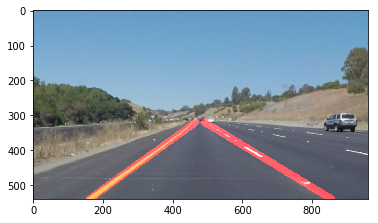

solidWhiteCurve.jpg


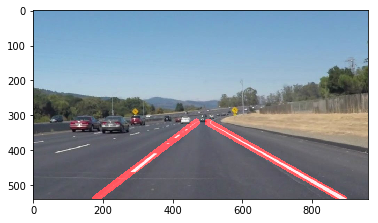

solidYellowCurve2.jpg


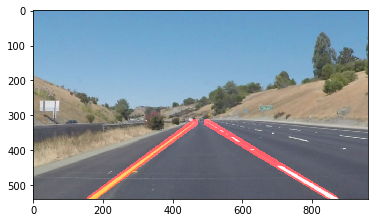

solidYellowLeft.jpg


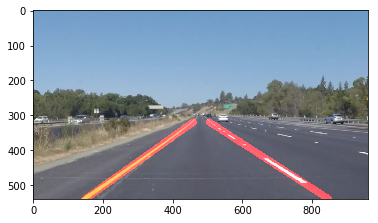

whiteCarLaneSwitch.jpg


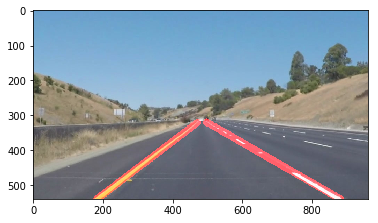

solidWhiteRight.jpg


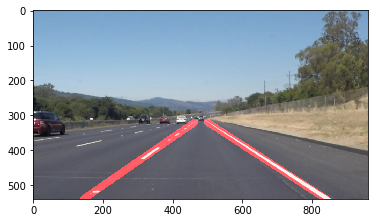

In [11]:
for v in test_imgs:
    reset_prev_lines()
    print(v)
    img = image_transform(v)

## Image Generation for Writeup

In [13]:
pd = pdict
img = mpimg.imread('test_images/solidWhiteRight.jpg')
rimg = grayscale(img)
grimg = gaussian_blur(rimg, pd['k_size'])
cimg = canny(grimg, pd['canny'][0], pd['canny'][1])
cv2.imwrite('test_images/canny_solidWhiteRight.jpg', cimg)
    
m_img = region_of_interest(cimg, pd['vertices'])
h_img = hough_lines(m_img, pd['hough']['rho'], pd['hough']['theta'], pd['hough']['threshold'], 
                    pd['hough']['min_line'], pd['hough']['max_line'])
cv2.imwrite('test_images/extrap_lines_solidWhiteRight.jpg', h_img)
    
w_img = weighted_img(img, h_img, 0.8, 1., 0.)
cv2.imwrite('test_images/final_solidWhiteRight.jpg', w_img)

True

## Test on Videos

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    pd = pdict
    rimg = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    grimg = gaussian_blur(rimg, pd['k_size'])
    cny_img = canny(grimg, pd['canny'][0], pd['canny'][1])
    m_img = region_of_interest(cny_img, pd['vertices'])
    h_img = hough_lines(m_img, pd['hough']['rho'], pd['hough']['theta'], pd['hough']['threshold'], 
                        pd['hough']['min_line'], pd['hough']['max_line'])
    w_img = weighted_img(img, h_img, 0.8, 1., 0.)
    return w_img

Let's try the one with the solid white lane on the right first ...

In [16]:
reset_prev_lines()
clip1_output = 'test_videos/final_solidWhiteRight.mp4'
test_clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
new_clip1 = test_clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip1.write_videofile(clip1_output, audio=False)

[MoviePy] >>>> Building video test_videos/final_solidWhiteRight.mp4
[MoviePy] Writing video test_videos/final_solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 50.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/final_solidWhiteRight.mp4 

CPU times: user 8.68 s, sys: 308 ms, total: 8.99 s
Wall time: 4.76 s


In [17]:
reset_prev_lines()
clip2_output = 'test_videos/final_solidYellowLeft.mp4'
test_clip2 = VideoFileClip("test_videos/solidYellowLeft.mp4")
new_clip2 = test_clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip2.write_videofile(clip2_output, audio=False)

[MoviePy] >>>> Building video test_videos/final_solidYellowLeft.mp4
[MoviePy] Writing video test_videos/final_solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:14<00:00, 47.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/final_solidYellowLeft.mp4 

CPU times: user 27.6 s, sys: 604 ms, total: 28.2 s
Wall time: 14.6 s
